In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import ast

%matplotlib inline

## read data file

In [2]:
#trip data
mydateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
trip_data = pd.read_csv('data/MarchMonthData_withRouteData.csv', parse_dates=['startDateTime','endDateTime'], date_parser=mydateparser)

#these datasets are prepared from the spatial join of origin and destination with MPO dataset in ArcGIS
#-----------------------------------------------------------------------------------------------------------
#origin landuse
origin_landuse = gpd.read_file(r'data\StartPoint_SpatialJoin_NashvilleMPO.shp')

#destination landuse
destination_landuse = gpd.read_file(r'data\EndPoint_SpatialJoin_NashvilleMPO.shp')
#-----------------------------------------------------------------------------------------------------------

In [3]:
#work with spatial join dataset
def add_spatial_data(trip_data, spatial_data,prefix):
#slice selected column and create new varibles
    columns_to_keep = ['trip_id','POP10','EMP10','AREA','EMP_ARG','EMP_MANU','EMP_TRANS','EMP_RET',
                       'EMP_OFFICE','CBD','URBAN','SU','RURAL','K12','COLLEGE','FTE_COMM','FTE_UNIV',
                       'STUDENT_K1','STUDENT_UN','HHSIZE_1','HHSIZE_2','HHSIZE_3','HHSIZE_4PL','INCOME_25K',
                       'INCOME_50K','INCOME_75K','INCOME_100','INCOME_101','WORKERS_0','WORKERS_1','WORKERS_2',
                       'WORKERS_3P','SINGLE_FAM','SINGLE_FA1','MULTI_UNIT','MOBILE_HOM','AGE0TO17','AGE18TO24',
                       'AGE25TO34','AGE35TO49','AGE50TO64','AGE65TO79','AGE80PLUS','CHILDREN_0','CHILDREN_1',
                       'HISPANIC','WHITE','BLACK','NINDIAN','ASIAN','ISLANDER','RACEOTHER','MIXED',
                       'MALE','FEMALE','GQ_INST','GQ_COLL','GQ_MIL','GQ_OTHER','HOTEL_ROOM','HOTEL_OCCU',
                      'SHT_PRK','LNG_PRK','NFL_DRAFT', 'VANDERBILT', 'PARK']
                       
    data_selected = spatial_data[columns_to_keep]
    data_selected['pop_density_perMile'] = data_selected.apply(lambda x: x['POP10']/x['AREA'], axis=1)
    data_selected['emp_density_perMile'] = data_selected.apply(lambda x: x['EMP10']/x['AREA'], axis=1)
    data_selected['SHT_PRK_density'] = data_selected.apply(lambda 
                                                                  x: x['SHT_PRK']/x['AREA'], 
                                                                  axis=1)
    data_selected['LNG_PRK_density'] = data_selected.apply(lambda 
                                                                  x: x['LNG_PRK']/x['AREA'], 
                                                                  axis=1)

 

    ##-----------------normalize data----------------------------------    
    #normalize by total population
    normalize_var_by_pop = ['FTE_COMM','FTE_UNIV','STUDENT_K1','STUDENT_UN',
                            'HHSIZE_1','HHSIZE_2','HHSIZE_3','HHSIZE_4PL',
                            'INCOME_25K','INCOME_50K','INCOME_75K','INCOME_100','INCOME_101',
                            'WORKERS_0','WORKERS_1','WORKERS_2','WORKERS_3P',
                            'SINGLE_FAM','SINGLE_FA1','MULTI_UNIT','MOBILE_HOM',
                            'AGE0TO17','AGE18TO24','AGE25TO34','AGE35TO49','AGE50TO64','AGE65TO79','AGE80PLUS',
                            'CHILDREN_0','CHILDREN_1',
                           'HISPANIC','WHITE','BLACK','NINDIAN','ASIAN','ISLANDER','RACEOTHER','MIXED',
                           'MALE','FEMALE',
                           'GQ_INST','GQ_COLL','GQ_MIL','GQ_OTHER']
    normalize_var_by_pop_names = [str(var+'_percent') for var in normalize_var_by_pop]

    for var in normalize_var_by_pop:
        data_selected[str(var+'_percent')] = data_selected.apply(lambda x : 0 if x['POP10']==0 
                                                                             else x[var]/x['POP10']*100, axis=1)

    #nomralize by total employment
    normalize_var_by_emp = ['EMP_ARG','EMP_MANU','EMP_TRANS','EMP_RET','EMP_OFFICE']
    normalize_var_by_emp_names = [str(var+'_percent') for var in normalize_var_by_emp]

    for var in normalize_var_by_emp:
        data_selected[str(var+'_percent')] = data_selected.apply(lambda x : 0 if x['EMP10']==0 
                                                                             else x[var]/x['EMP10'], axis=1)
    #------------------------------------------------------------------------------

    other_var_to_keep =['trip_id','SHT_PRK_density','LNG_PRK_density','AREA','HOTEL_ROOM',
                        'pop_density_perMile','emp_density_perMile','CBD','URBAN','SU','RURAL',
                       'NFL_DRAFT', 'VANDERBILT', 'PARK']
    
    #create a dataframe with variables normalized and other variables
    data_selected = data_selected[other_var_to_keep+normalize_var_by_pop_names+normalize_var_by_emp_names]

    #rename columns of data set
    data_selected = data_selected.add_prefix(prefix+'_')
    
    #merge two data
    merged_data = pd.merge(trip_data, data_selected, left_on='trip_id', right_on=prefix+'_trip_id', how='inner')
    
    #drop columns (care about prefex for column name)
    merged_data = merged_data.drop(columns=[prefix+'_trip_id', 
                                            #prefix+'_POP10', 
                                            #prefix+'_EMP10'
                                           ])
    
    return merged_data


In [4]:
#call functions to merge landuse attributes to trip dataset
trip_origin = add_spatial_data(trip_data,origin_landuse,'origin')
trip_origin_destination = add_spatial_data(trip_origin,destination_landuse,'destination')

C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\nshah12\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [5]:
#check for lenght of dataframe for all merges
origin_landuse.shape[0]==trip_origin.shape[0]==destination_landuse.shape[0]==trip_origin_destination.shape[0]

True

In [6]:
(list(trip_origin_destination.columns))

['Unnamed: 0',
 'Unnamed: 0.1',
 'trip_id',
 'companyName',
 'tripRecordNum',
 'sumdID',
 'tripDuration',
 'tripDistance',
 'startLatitude',
 'startLongitude',
 'endLatitude',
 'endLongitude',
 'tripRoute',
 'startDateTime',
 'endDateTime',
 'tripDistance_miles',
 'origin_SHT_PRK_density',
 'origin_LNG_PRK_density',
 'origin_AREA',
 'origin_HOTEL_ROOM',
 'origin_pop_density_perMile',
 'origin_emp_density_perMile',
 'origin_CBD',
 'origin_URBAN',
 'origin_SU',
 'origin_RURAL',
 'origin_NFL_DRAFT',
 'origin_VANDERBILT',
 'origin_PARK',
 'origin_FTE_COMM_percent',
 'origin_FTE_UNIV_percent',
 'origin_STUDENT_K1_percent',
 'origin_STUDENT_UN_percent',
 'origin_HHSIZE_1_percent',
 'origin_HHSIZE_2_percent',
 'origin_HHSIZE_3_percent',
 'origin_HHSIZE_4PL_percent',
 'origin_INCOME_25K_percent',
 'origin_INCOME_50K_percent',
 'origin_INCOME_75K_percent',
 'origin_INCOME_100_percent',
 'origin_INCOME_101_percent',
 'origin_WORKERS_0_percent',
 'origin_WORKERS_1_percent',
 'origin_WORKERS_2_per

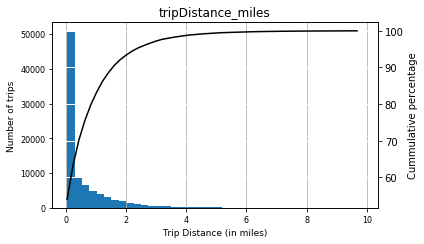

In [7]:
fig, ax = plt.subplots(figsize=(6,3.5))

ax2=ax.twinx()
trip_origin_destination.hist('tripDistance_miles', ax=ax, bins=40)


data_distance = trip_origin_destination[['tripDistance_miles']]
# evaluate the histogram
values, base = np.histogram(data_distance, bins=50)
#evaluate the cumulative
cumulative = np.cumsum(values)
# plot the cumulative function
ax2.plot(base[:-1], cumulative/cumulative[-1]*100, color='black', linewidth=1.5)
ax2.set_ylabel('Cummulative percentage')

ax.grid(color='w', linestyle='-',axis='y', linewidth=0)


ax2.grid(color='w', linestyle='-', linewidth=1)
ax.set_xlabel('Trip Distance (in miles)', fontsize=9)
ax.set_ylabel('Number of trips', fontsize=9)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax2.tick_params(axis='both', which='minor', labelsize=8)

#plt.title('Trip distance cummulative distribution')
plt.tight_layout()
#plt.savefig('Results_for_report/Tripdistance_plot.png', dpi=900)

## quick metrics for trip directness

In [8]:
from math import cos, asin, sqrt
#calcute distance between two WGS points and returns value in ft
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return (12742 * asin(sqrt(a)))*0.621371*5280 #2*R*asin...


def trip_distance(GPS_trace_data):
    a=0
    
    #remove empty list in tripRoute data
    GPS_trace_data = [x for x in GPS_trace_data if x != []]
    
    for point_id in np.arange(len(GPS_trace_data)-1):
        a+=distance(GPS_trace_data[point_id][0],
                    GPS_trace_data[point_id][1],
                    GPS_trace_data[point_id+1][0],
                    GPS_trace_data[point_id+1][1])
    return a

#### create some new variables

In [9]:
#some landuse attributes is null because those points are in the river; for removing them
trip_origin_destination.isnull().sum()
trip_origin_destination=trip_origin_destination.dropna()



#calculate euclidean distance and distance from GPS trace
trip_origin_destination['euclidean_distance'] = trip_origin_destination.apply(lambda x:
                                                                              distance(x['startLatitude'],
                                                                                       x['startLongitude'],
                                                                                       x['endLatitude'],
                                                                                       x['endLongitude']), axis=1)

trip_origin_destination['distance_GPS_trace']=trip_origin_destination.apply(lambda x: 
                                                                            trip_distance(ast.literal_eval(x['tripRoute'])),
                                                                            axis=1)

trip_origin_destination['average_trip_speed_mph']=trip_origin_destination.apply(lambda x: 
                                                                                x['tripDistance']/(x['tripDuration']*60)*0.681818, 
                                                                                axis=1)



#create a variable name with trip start hour and week number (Monday=0 and Sunday=6)
trip_origin_destination['trip_start_week_no']=trip_origin_destination.apply(lambda x: x['startDateTime'].weekday(), axis=1)
trip_origin_destination['trip_start_hour_no']=trip_origin_destination.apply(lambda x: x['startDateTime'].hour, axis=1)

trip_origin_destination['weekend_trip']=trip_origin_destination.apply(lambda x:1 if x['trip_start_week_no']>=5 else 0, axis=1)

trip_origin_destination['distance_GPS_trace_miles']=trip_origin_destination.apply(lambda x:x['distance_GPS_trace']/5280, axis=1)

#remove trip distance less than 3 miles
#trip_origin_destination=trip_origin_destination[trip_origin_destination['distance_GPS_trace_miles']<3]

# transform landuse data to categorical variables
# get 75 percentile values for each variables
# break_level = 0.75
# origin_emp_density_perMile_break=trip_origin_destination['origin_emp_density_perMile'].quantile(break_level)
# destination_emp_density_perMile_break=trip_origin_destination['destination_emp_density_perMile'].quantile(break_level)
# destination_pop_density_perMile_break=trip_origin_destination['destination_pop_density_perMile'].quantile(break_level)
# origin_pop_density_perMile_break=trip_origin_destination['origin_pop_density_perMile'].quantile(break_level)
# #use the above value to create catergorical variable
# trip_origin_destination['origin_emp_density_perMile_High']=trip_origin_destination.apply(lambda x: 
#                                                    1 if x['origin_emp_density_perMile']>origin_emp_density_perMile_break
#                                                    else 0, axis=1)
# trip_origin_destination['destination_emp_density_perMile_High']=trip_origin_destination.apply(lambda x: 
#                                                    1 if x['destination_emp_density_perMile']>destination_emp_density_perMile_break
#                                                    else 0, axis=1)
# trip_origin_destination['destination_pop_density_perMile_High']=trip_origin_destination.apply(lambda x: 
#                                                    1 if x['destination_pop_density_perMile']>destination_pop_density_perMile_break
#                                                    else 0, axis=1)
# trip_origin_destination['origin_pop_density_perMile_High']=trip_origin_destination.apply(lambda x: 
#                                                    1 if x['origin_pop_density_perMile']>origin_pop_density_perMile_break
#                                                    else 0, axis=1)

#dummy variable for trip start time
trip_origin_destination['StartTime_AMPeak']=trip_origin_destination.apply(lambda x: 
                                                                          1 if x['trip_start_hour_no']>7 and x['trip_start_hour_no']<=10 else 0, axis=1)
trip_origin_destination['StartTime_Day']=trip_origin_destination.apply(lambda x: 
                                                                       1 if x['trip_start_hour_no']>10 and x['trip_start_hour_no']<=16 else 0, axis=1)
trip_origin_destination['StartTime_PMPeak']=trip_origin_destination.apply(lambda x: 
                                                                          1 if x['trip_start_hour_no']>16 and x['trip_start_hour_no']<=20 else 0, axis=1)
trip_origin_destination['StartTime_Night']=trip_origin_destination.apply(lambda x: 
                                                                         1 if x['trip_start_hour_no']>20 or x['trip_start_hour_no']<=7 else 0, axis=1)


In [10]:
#verify that some trip distance in the dataset is much larger than euclidean distance
(trip_origin_destination['euclidean_distance']>trip_origin_destination['distance_GPS_trace']).value_counts()

False    82228
True      6567
dtype: int64

In [11]:
trip_origin_destination_copy = trip_origin_destination.copy()
trip_origin_destination[['tripDistance','euclidean_distance']].describe()

,tripDistance,euclidean_distance
count,88795.000000,88795.000000
mean,3290.817997,3181.547433
std,5007.899211,2715.339070
min,200.131240,0.000000
25%,395.935200,1329.613025
50%,984.252000,2582.478884
75%,4265.092000,4199.481899
max,52112.862560,35834.062237


In [12]:
count_original_trips=len(trip_origin_destination)

#For some trips, the distance from GPS trace is greater than euclidean_distance, thus removing those
trip_origin_destination = trip_origin_destination[trip_origin_destination['distance_GPS_trace']>trip_origin_destination['euclidean_distance']]
count_remove_route_directness = len(trip_origin_destination)

#remove trips with euclidean distance 0
trip_origin_destination = trip_origin_destination[trip_origin_destination['euclidean_distance']>0]
count_remove_euclidean_distance_zero = len(trip_origin_destination)

#remove trips with duration more than 90 minutes
trip_origin_destination = trip_origin_destination[trip_origin_destination['tripDuration']<90]
count_remove_duration = len(trip_origin_destination)

#remove trips with average speed above 15 mph
trip_origin_destination=trip_origin_destination[trip_origin_destination['average_trip_speed_mph']<15]
count_remove_average_speed = len(trip_origin_destination)

#remove trips with trip distance >2 miles
trip_origin_destination= trip_origin_destination[(trip_origin_destination['tripDistance_miles']<3)]
count_remove_trip_distance = len(trip_origin_destination)




In [13]:
count_summary={'original trip: ':len(trip_data) ,
               'trips removed for missing values':len(trip_data)-count_original_trips,   
               'trips removed for GPS trace greater than euclidean distance: ': count_original_trips-count_remove_route_directness,
                  'trips removed for euclidean distance less than zero: ': count_remove_route_directness-count_remove_euclidean_distance_zero,
               'trips removed for duration greater than 90 minutes: ': count_remove_euclidean_distance_zero-count_remove_duration,
                   'trips removed for average speed greater than 30 mph: ': count_remove_duration-count_remove_average_speed,
                   'trips removed for distance greater than 3 mile: ': count_remove_average_speed-count_remove_trip_distance,
               'remaining number of trips: ': len(trip_origin_destination)
                  }
count_summary

{'original trip: ': 88863,
 'trips removed for missing values': 68,
 'trips removed for GPS trace greater than euclidean distance: ': 6587,
 'trips removed for euclidean distance less than zero: ': 113,
 'trips removed for duration greater than 90 minutes: ': 372,
 'trips removed for average speed greater than 30 mph: ': 14,
 'trips removed for distance greater than 3 mile: ': 2700,
 'remaining number of trips: ': 79009}

In [14]:
#calculate trip directness
trip_origin_destination['route_directness']=trip_origin_destination.apply(lambda x:
                                                                          x['euclidean_distance']/x['distance_GPS_trace'], 
                                                                          axis=1)

In [16]:
#save data
trip_origin_destination.drop(columns=['tripRoute']).to_csv('data/MarchMonth_landuse_percentageVar_RouteDirectness__WithFlags_withoutRouteData.csv')

In [17]:
print("number of removed trips:",(len(trip_data)-len(trip_origin_destination)))
print("number of removed trips:",(len(trip_data)-len(trip_origin_destination))/len(trip_data)*100)

number of removed trips: 9854
number of removed trips: 11.088979665327527
